In [42]:
import os

import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread

from scripts.sample_db import SampleDB
from scripts.utils.traces_utils import load_traces,plot_traces_with_mean


In [12]:

# Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)
print(sample_db)

# Load experiment
sample_id = '20220426_RM0008_130hpf_fP1_f3'
exp = sample_db.get_sample(sample_id)
print(exp.sample.id)

# Shortcuts for sample parameters
sample = exp.sample
raw_path = exp.paths["raw_path"]
anatomy_path = exp.paths["anatomy_path"]
em_path = exp.paths["em_path"]
n_planes = exp.params_lm.n_planes
n_frames = exp.params_lm.n_frames
n_slices = exp.params_lm.lm_stack_range
doubling = 2 if exp.params_lm.doubling else 1

# Get paths of the trial acquisitions
trial_paths = [os.path.splitext(path)[0] for path in os.listdir(os.path.join(raw_path, "trials"))]
print(trial_paths)

# Define paths for preprocessed and masks folders
preprocessed_folder = os.path.join(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3", "preprocessed")
os.makedirs(preprocessed_folder, exist_ok=True)
masks_folder = os.path.join(preprocessed_folder, "..", "masks")
os.makedirs(masks_folder, exist_ok=True)

# Load masks
all_masks = []
for plane in range(n_planes*doubling):
    plane_str = f"{plane:02d}"
    mask_path = os.path.join(masks_folder, f"mask_plane_{plane_str}.tif")
    masks = imread(mask_path)
    all_masks.append(masks)
all_masks = np.array(all_masks)

# Create folder for saving fluorescence data
traces_folder = os.path.join(preprocessed_folder, "..", "traces")
os.makedirs(traces_folder, exist_ok=True)

# Calculate and save fluorescence intensity
for plane in range(n_planes*doubling):
    plane_str = f"{plane:02d}"
    for trial_idx, trial_path in enumerate(trial_paths):
        movie_path = os.path.join(preprocessed_folder, f"transformed_plane_{plane_str}_{trial_path}.tif")
        movie = imread(movie_path)
        mask = all_masks[plane, trial_idx,:,:]

        trial_fluorescence = {}
        for label in np.unique(mask):
            if label != 0:
                label_mask = mask == label
                fluorescence_values = movie[:, label_mask].mean(axis=1)
                trial_fluorescence[label] = fluorescence_values
        
        # Save the fluorescence data for the current plane and trial
        traces_file_path = os.path.join(traces_folder, f"traces_plane_{plane_str}_{trial_path}.npy")
        np.save(traces_file_path, trial_fluorescence)
        print(f"Fluorescence data saved at {traces_file_path}")

print("Fluorescence intensities calculated and saved.")



SampleDB(sample_ids=['20220426_RM0008_130hpf_fP1_f3'])
20220426_RM0008_130hpf_fP1_f3
['20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o2Ser_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o3Ctrl_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o4TCA_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o5GCA_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o6TDCA_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o7Cad_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o8SA_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o1Ala_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o2Ser_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o3Ctrl_002_', '20220426_RM0008_130hpf_fP1_f3_t2_o4TCA_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o5GCA_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o6TDCA_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o7Cad_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o8SA_001_', '20220426_RM0008_130hpf_fP1_f3_t3_o1Ala_001_', '20220426_RM0008_130hpf_fP1_f3_t3_o2Ser_001_', '20220426_RM0008_130hpf_fP1_f3_t3_o3Ctrl_001_', '20220426_RM0008_1

           0            1            2            3            4    \
1  8138.243517  8147.304397  8125.429784  8125.270551  8125.690504   
2  8136.140968  8140.703245  8125.029527  8125.431750  8125.797206   
5  8145.673165  8142.196345  8125.446916  8125.326624  8126.330433   
6  8147.697583  8138.441984  8125.191043  8125.546737  8125.863109   
7  8134.149112  8132.270850  8125.444084  8125.082094  8126.146174   

           5            6            7            8            9    ...  \
1  8125.168813  8126.013135  8126.243162  8124.795700  8125.876388  ...   
2  8124.894663  8125.385751  8126.218506  8124.853275  8125.290506  ...   
5  8124.796719  8125.062440  8125.754156  8125.117151  8125.750096  ...   
6  8125.269336  8125.672379  8126.116623  8125.265217  8125.265520  ...   
7  8124.670162  8125.837849  8126.648313  8125.096768  8125.306156  ...   

           365          366          367          368          369  \
1  8137.010047  8145.164126  8136.001305  8140.413724  813

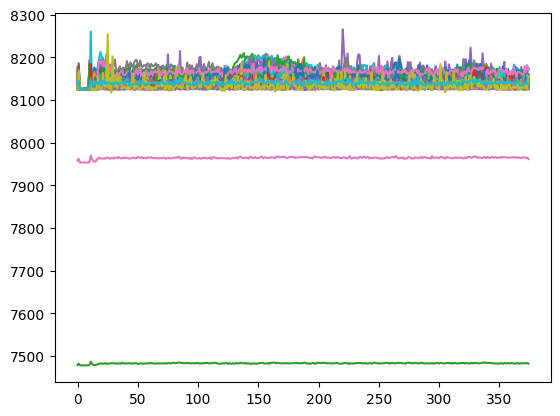

In [49]:

# Example path to a fluorescence data file
traces_file_path = r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\..\masks\traces\traces_plane_03_20220426_RM0008_130hpf_fP1_f3_t1_o2Ser_001_.npy"
traces = load_traces(traces_file_path)
print(traces.T.head())
traces.plot()
plt.legend().set_visible(False)


In [13]:
# Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)
print(sample_db)

# Load experiment
sample_id = '20220426_RM0008_130hpf_fP1_f3'
exp = sample_db.get_sample(sample_id)
print(exp.sample.id)

# Shortcuts for sample parameters
sample = exp.sample
raw_path = exp.paths["raw_path"]
anatomy_path = exp.paths["anatomy_path"]
em_path = exp.paths["em_path"]
n_planes = exp.params_lm.n_planes
n_frames = exp.params_lm.n_frames
n_slices = exp.params_lm.lm_stack_range
doubling = 2 if exp.params_lm.doubling else 1

# Get paths of the trial acquisitions
trial_paths = [os.path.splitext(path)[0] for path in os.listdir(os.path.join(raw_path, "trials"))]
print(trial_paths)

SampleDB(sample_ids=['20220426_RM0008_130hpf_fP1_f3'])
20220426_RM0008_130hpf_fP1_f3
['20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o2Ser_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o3Ctrl_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o4TCA_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o5GCA_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o6TDCA_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o7Cad_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o8SA_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o1Ala_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o2Ser_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o3Ctrl_002_', '20220426_RM0008_130hpf_fP1_f3_t2_o4TCA_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o5GCA_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o6TDCA_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o7Cad_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o8SA_001_', '20220426_RM0008_130hpf_fP1_f3_t3_o1Ala_001_', '20220426_RM0008_130hpf_fP1_f3_t3_o2Ser_001_', '20220426_RM0008_130hpf_fP1_f3_t3_o3Ctrl_001_', '20220426_RM0008_1

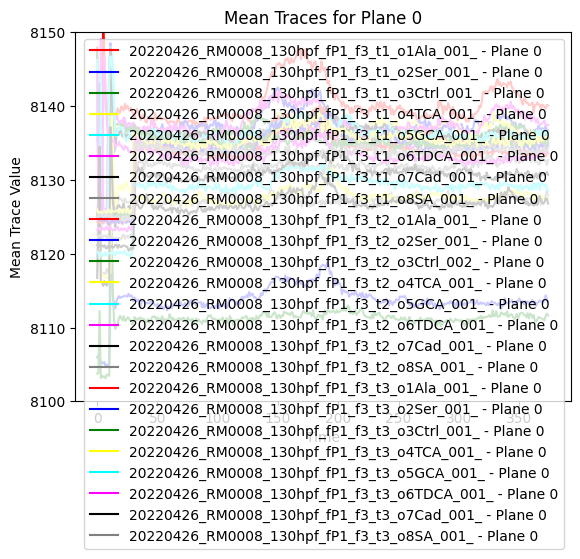

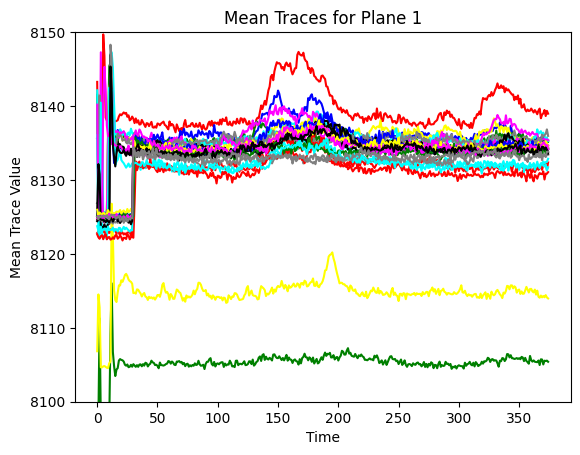

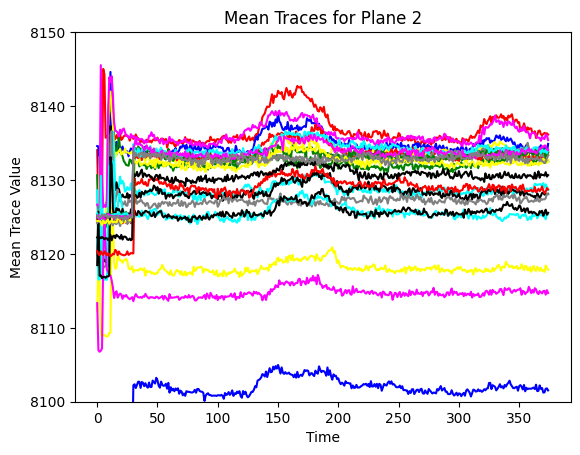

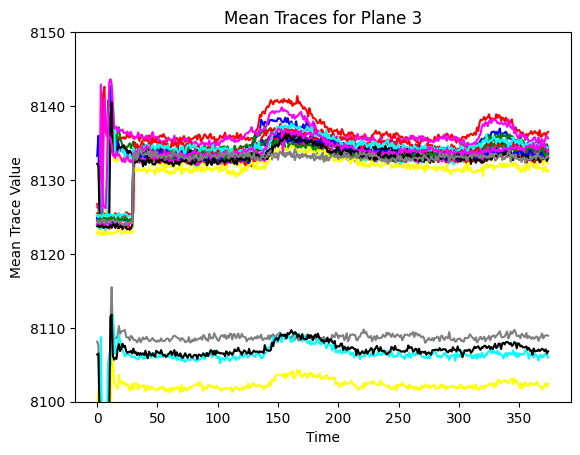

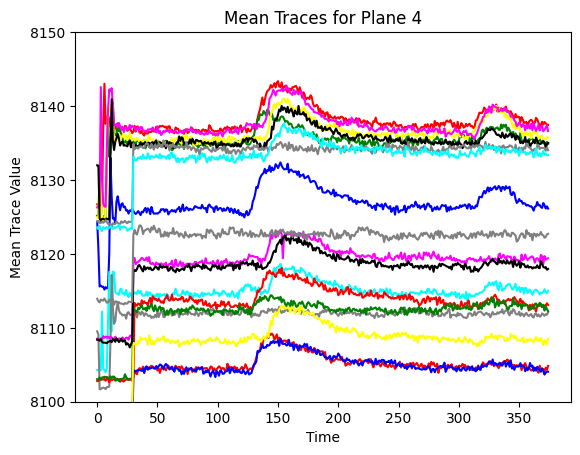

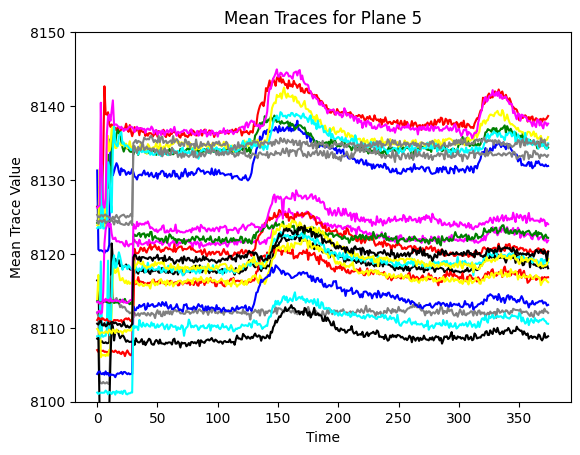

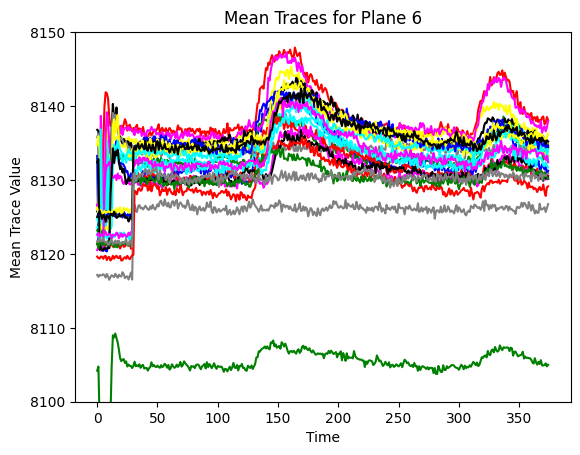

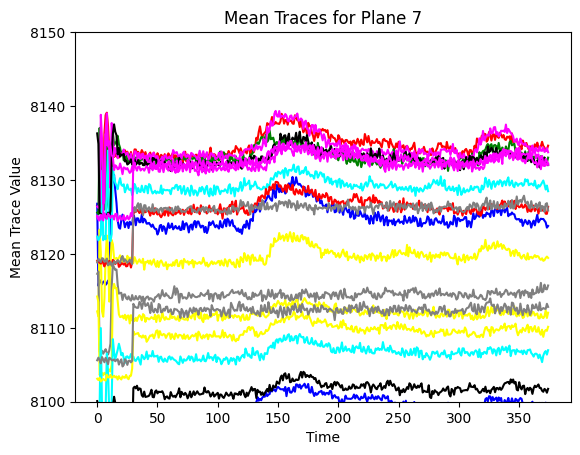

In [40]:
# Mean traces
from scripts.utils.traces_utils import load_traces
colors = ["red", "blue", "green", "yellow", "cyan", "magenta", "black", "gray"]

for plane in range(n_planes * doubling):
    plane_str = f'{plane:02d}'
    plt.figure()  # Create a new figure for each plane
    
    for i, path in enumerate(trial_paths):
        trace_path = os.path.join(traces_folder, f"traces_plane_{plane_str}_{path}.npy")
        traces = load_traces(trace_path)
        traces_mean = traces.mean(axis=1)
        
        # Plot the mean trace with a label and color
        plt.plot(traces_mean, label=f"{path} - Plane {plane}", color=colors[i % len(colors)])
    
    # Set plot limits and add legend
    plt.ylim((8100, 8150))

    plt.legend().set_visible(True) if plane == 0 else None
    
    plt.title(f"Mean Traces for Plane {plane}")
    plt.xlabel("Time")
    plt.ylabel("Mean Trace Value")
    plt.show()  # Display the plot

